In [ ]:
#FINE TUNING
#1. Model -> bert-large-uncased-whole-word-masking-finetuned-squad
#2. Dataset -> Legal Dataset
#3. Batch size -> 16

#Steps
#1. Loading the Dataset
#2. Processing the Data
#3. Fine Tuning
#4. Evaluation

In [ ]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 225kB 2.9MB/s 
     |████████████████████████████████| 112kB 13.2MB/s 
     |████████████████████████████████| 245kB 12.7MB/s 
     |████████████████████████████████| 2.3MB 3.0MB/s 
     |████████████████████████████████| 901kB 18.9MB/s 
     |████████████████████████████████| 3.3MB 21.7MB/s 
  Found existing installation: huggingface-hub 0.0.9
    Uninstalling huggingface-hub-0.0.9:
      Successfully uninstalled huggingface-hub-0.0.9


**Fine Tuning Parameters**

In [ ]:
#Pretrained Model Name
model = "bert-large-uncased-whole-word-masking-finetuned-squad"

#Dataset Files
training_file = "train_dataset.json"
validation_file = "validate_dataset.json"
test_file = "test_dataset.json"

#Batch_size for training
batch_size = 16

## **Loading Dataset**

In [ ]:
#Loading the Dataset
from datasets import load_dataset
dataset = load_dataset('json', data_files={'train': training_file, 'validation': validation_file, 'test': test_file}, field='data')
#Viewing the attributes and features of the datasets
print(dataset)

Using custom data configuration default-8197eb83e4aa3ea4


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-8197eb83e4aa3ea4/0.0.0/83d5b3a2f62630efc6b5315f00f20209b4ad91a00ac586597caee3a4da0bef02. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['title', 'id', 'context', 'question', 'answer'],
        num_rows: 1986
    })
    validation: Dataset({
        features: ['title', 'id', 'context', 'question', 'answer'],
        num_rows: 228
    })
    test: Dataset({
        features: ['title', 'id', 'context', 'question', 'answer'],
        num_rows: 168
    })
})


## **Data Processing**

In [ ]:
#Processing the Data
import transformers
from transformers import AutoTokenizer

#Fetching the Fast Tokenizer(if available) for the ML model
tokenizer = AutoTokenizer.from_pretrained(model)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

#Function to prepare the train examples for training
def prepare_train_samples(examples):
    max_length = 480    #max length of the input(question+context)
    doc_stride = 128    #length of overlap between consecutive samples of the same example

    #Tokenizing with truncation and padding, but keeping the overflows using a stride.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    #One example might give us several samples if it has a long context
    #a mapping indicating the map from the sample to its corresponding example
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    #offset mappings give us a map from token to character position spans in the original context
    offset_mapping = tokenized_examples.pop("offset_mapping")

    #labeling of the examples with the start and end character positions of the answer
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]

        #the impossible answers are marked with the index of the CLS token.
        cls_index = input_ids.index(tokenizer.cls_token_id)

        #Grab the sequence corresponding to that sample (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        #One example can give several samples
        #fetching the original example number for the sample
        example_index = sample_mapping[i]
        answer = examples["answer"][example_index]
        
        #Start/end character indexes for the answer in the example
        start_char_index = answer["answer_start"]
        end_char_index = answer["answer_end"] + 1

        #Start token index for the current sample context
        token_start_index = 0
        while sequence_ids[token_start_index] != 1:
            token_start_index += 1

        #End token index for the current sample context
        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != 1:
            token_end_index -= 1

        #Detect if the answer is out of the span and label the sample with the CLS index
        if not (offsets[token_start_index][0] <= start_char_index and offsets[token_end_index][1] >= end_char_index):
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        #bringing the token_start_index and token_end_index to the answer_start_index and the answer_end_index respectively
        #the last offset is considered in case of the last word answer
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char_index :
                token_start_index += 1
            tokenized_examples["start_positions"].append(token_start_index - 1)
            while offsets[token_end_index][1] >= end_char_index:
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
#Preparing the tokenized data input
tokenized_dataset = dataset.map(prepare_train_samples, batched=True, remove_columns=dataset["train"].column_names)

## **Fine Tuning**

In [ ]:
#Fine Tuning
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

#fetching the pre-trained model
model = AutoModelForQuestionAnswering.from_pretrained(model)

#Not changing the base parameters of the model(Non-Task specific layer)
for param in model.base_model.parameters():
    param.requires_grad = False

#Defining the Training Arguments
args = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir = './logs',
    logging_steps = 10
)

In [ ]:
#Fetching the Data Collator to batch the processed examples
from transformers import default_data_collator
data_collator = default_data_collator

In [ ]:
#Defining the trainer Object for training
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

#Train the model (with evaluation loss only)
trainer.train()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,0.588900,0.586019,25.372300,9.104000
2,0.576700,0.577451,25.531200,9.048000
3,0.550800,0.572990,25.629000,9.013000
4,0.514100,0.571728,26.013400,8.880000


TrainOutput(global_step=508, training_loss=0.5645245191619153, metrics={'train_runtime': 1031.6647, 'train_samples_per_second': 0.492, 'total_flos': 7812996550732800.0, 'epoch': 4.0, 'init_mem_cpu_alloc_delta': 1418604544, 'init_mem_gpu_alloc_delta': 1337192960, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 12279808, 'train_mem_gpu_alloc_delta': 188928, 'train_mem_cpu_peaked_delta': 1425408, 'train_mem_gpu_peaked_delta': 1589957120})

In [ ]:
#Saving the trained model
trainer.save_model("LegalTrained")

## **Evaluation**

In [ ]:
#Evaluation
#Function to prepare the validation examples for evaluation
def prepare_test_samples(examples):
    max_length = 480    #max length of input(question + context)
    doc_stride = 128    #length of overlap between consecutive samples of the same example

    #Tokenizing with truncation and padding, but keeping the overflows using a stride
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    #One example might give us several samples if it has a long context
    #a mapping indicating the map from the sample to its corresponding example
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    #recording the example_id that gave us this sample
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        #Grab the sequence corresponding to that sample (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        #One example can give several samples
        #fetching the original example number for the sample
        sample_index = sample_mapping[i]
        #apeending the example_id for fetching the reference answer for evaluation
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        #the offset_mapping of tokens that are not part of the context is set to None
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == 1 else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
#preparing the validation input
test_samples = dataset["test"].map(
    prepare_test_samples,
    batched=True,
    remove_columns=dataset["test"].column_names
)

#Getting the raw predictions on the test set
raw_predictions = trainer.predict(test_samples)

In [ ]:
from tqdm.auto import tqdm
import numpy as np
import collections

#Function to find the best possible answers using the raw predictions
def postprocess_qa_predictions(examples, samples, raw_predictions, best_size = 20, max_answer_length = 100):
    #fetching the start and end scores for the predicted answers
    all_start_logits, all_end_logits = raw_predictions

    #Building a mapping of examples to its samples list
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    samples_per_example = collections.defaultdict(list)
    for i, sample in enumerate(samples):
        samples_per_example[example_id_to_index[sample["example_id"]]].append(i)

    #final predictions to be worked from the raw predictions
    predictions = collections.OrderedDict()

    for example_index, example in enumerate(tqdm(examples)):
        #indices of the samples associated to the current example.
        sample_indices = samples_per_example[example_index]

        valid_answers = []                #the list of valid predicted answers for the example
        context = example["context"]      #the context for the example

        #Looping through all the samples associated to the current example.
        for sample_index in sample_indices:
            #fetching the predictions of the model for this sample
            start_logits = all_start_logits[sample_index]
            end_logits = all_end_logits[sample_index]

            #Mapping to map the logit indexes to the characters in the context
            offset_mapping = samples[sample_index]["offset_mapping"]

            #Fetching the top 'best_size' start and end logits
            start_indexes = np.argsort(start_logits)[-1 : -best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -best_size - 1 : -1].tolist()

            #Looping through all combinations of start and end indexes to find the best valid answer among all
            for start_index in start_indexes:
                for end_index in end_indexes:
                    #Not considering answers which are out of the context or not in the context
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue

                    #Not considering answers with length < 0 or > max_answer_length
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    #Appending the valid answer along with its final score
                    #Final score = start_score + end_score
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        #Finding the best answer among all the possible valid answers based on the final score
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        #To avoid failure of no answers, we create a blank answer with score = 0.0
        else:
            best_answer = {"text": "", "score": 0.0}
        
        predictions[example["id"]] = best_answer["text"]
    return predictions

In [ ]:
#Getting the column names of the test_samples
test_samples.set_format(type=test_samples.format["type"], columns=list(test_samples.features.keys()))

#finding the final predictions (the best possible answers)
final_predictions = postprocess_qa_predictions(dataset["test"], test_samples, raw_predictions.predictions)

In [ ]:
#Constructing the predicted and reference answer sets for evaluation
predictions = tuple([v for k, v in final_predictions.items()])
references = []
for ex in dataset['test']:
    references.append(ex["context"][ex["answer"]["answer_start"] : ex["answer"]["answer_end"]+1])
references = tuple(references)

In [ ]:
#Evaluation Metric Function
import re
from collections import Counter

#Function to compute the Accuracy and the F1 score
#Predictions -> Predictions by the model
#References -> Reference items, to compare with the predictions
def compute(predictions, references):
    predictions_score = 0
    common_cnt = 0
    predicted_cnt = 0
    reference_cnt = 0
    predictions = list(predictions)
    references = list(references)
    wtclass_cnt = [0, 0, 0, 0, 0]

    for i in range(len(predictions)) :
        #Converting all the lower case
        references[i] = references[i].lower()
        predictions[i] = predictions[i].lower()

        #Removing the punctuations
        references[i] = re.sub(r'[^\w\s]', ' ', references[i])
        predictions[i] = re.sub(r'[^\w\s]', ' ', predictions[i])

        #Fetching the individual tokens
        references[i] = references[i].split()
        predictions[i] = predictions[i].split()

        #Finding the number of common words between the predicted item and the reference item
        cnt_common = sum(( Counter(references[i]) & Counter(predictions[i]) ).values())

        #Evaluating the difference counts for f1 measurement
        common_cnt += cnt_common
        predicted_cnt += len(predictions[i])
        reference_cnt += len(references[i])

        #Evaluating the match fraction of the prediction with the reference
        match_ratio = cnt_common / len(references[i])

        #Evaluating the scores based on the amount of match
        if match_ratio >= 0.25 and match_ratio < 0.5 :
            predictions_score += 1
            wtclass_cnt[1] += 1
        elif match_ratio >= 0.5 and match_ratio < 0.75 :
            predictions_score += 2
            wtclass_cnt[2] += 1
        elif match_ratio >= 0.75 and match_ratio < 1 :
            predictions_score += 3
            wtclass_cnt[3] += 1
        elif match_ratio == 1 :
            predictions_score += 4
            wtclass_cnt[4] += 1
        else :
            wtclass_cnt[0] += 1

    #Total score for references
    reference_score = 4 * len(references)

    #Calculating Evaluation Metrics
    accuracy = predictions_score / reference_score * 100
    precision = common_cnt / predicted_cnt
    recall = common_cnt / reference_cnt
    F1 = ((2 * precision * recall) / (precision + recall)) * 100
    EM = (wtclass_cnt[4] / len(references)) * 100

    #Sending the result
    metric = dict()
    metric['accuracy'] = accuracy
    metric['precision'] = precision
    metric['recall'] = recall
    metric['f1'] = F1
    metric['em'] = EM
    metric['wtclass_cnt'] = wtclass_cnt
    return metric

In [ ]:
#Evaluating and printing the results
result = compute(predictions, references)

print("Accuracy : " + str(result['accuracy']))
print("Precision : " + str(result['precision']))
print("Recall : " + str(result['recall']))
print("F1 : " + str(result['f1']))
print("Exact Match : " + str(result['em']))

Accuracy : 84.22619047619048
Precision : 0.9352905931695626
Recall : 0.6437113402061856
F1 : 76.2579384465071
Exact Match : 77.38095238095238


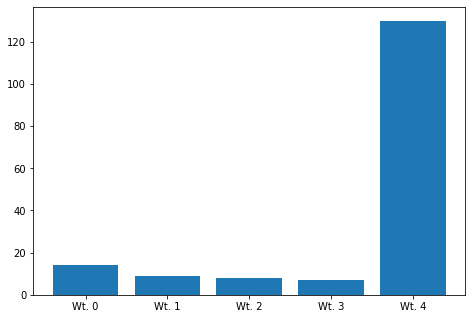

In [ ]:
#plotting the bar graph for the distribution of answers based on weight classes
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
wtclasses = ['Wt. 0', 'Wt. 1', 'Wt. 2', 'Wt. 3', 'Wt. 4']
answer_cnt = result['wtclass_cnt']
ax.bar(wtclasses, answer_cnt)
plt.show()